# Step 1: Business understanding
## **Context**
Our company has been sought avocados in all over US, with two type of avocado. They are sought in bags (Small, Large, XLarge) each time.
Now the company wanna to extends their business, so they want to know, "where, which, when" to do that. Also, recently, they have been collected a lots of invoice data, about the shop in regions all over the US. So, do we can use the data collected, to answer their question?

## **Objective**
The core of this problem is Explortary Data Analysis, so in this notebook, we will look deeply at the data, and extract insight from its.
Also, we should build a regression model to predict avocado price, to know the price we should sell, buy avocado in each region.

## Preparing toolkit (import libraries)

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp
from scipy.stats import chi2_contingency, f_oneway, chisquare
import time
import phik

#For feature engineering
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#Model
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

#Evalution Model
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error


def line(sep = '*'):
    print('\n'+sep*20)

In [2]:
# Custom css for data visualization
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.titlesize': 'x-large',
          'figure.figsize': (13, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Step 2: Data understanding

## Data context

Data was collected directly in all over retail stores ò the company base on their sale. It was collected from 4/2015 to 3/2018.
The average price in the csv file, is reflect only for per avocado in total.
Also the product lookup code in data is only for Hass avocado, not for any other type of product.


## Data content
Toàn bộ dữ liệu được đổ ra và lưu trữ trong tập tin avocado.csv
với 18249 record. Với các cột:
The data was saved in a csv file name "avocado.csv" with total 18249 records, and 10 colums as description bellow:
 Date - The date records
 AveragePrice – Average price per avocado
 Type - conventional / organic
 Region – The region the retail shop locate
 Total Volume – Total volumes have been sought
 4046 – Total volumes of avocado with PLU id 4046
 4225 - Total volumes of avocado with PLU id 4425
 4770 - Total volumes of avocado with PLU id 4770
 Total Bags – Total bas has been sought
 Small/Large/XLarge Bags – Total bas has been sought group by bag's size

### **Overview**
The data has been collected in all over the US, for three years. The data collected by date (day or month or year), with description as, average price, total volumes has sell, type of avocado...

In [ ]:
#Load data
df = pd.read_csv('avocado.csv', index_col=0)
df

In [4]:
#Take an overall look at df
profile = pp.ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Data diagnose

In overall, the data is quite clean, at that show us they was collected carefully. There are no sign of imbalance, missing, duplicate data. Beside, the data is focus on time, space, price, and volume.

But there still have some error:
1. Some columns has high correlation to each other: Total Volumes - 4026, 4225, Total Bags - Small Bags, LargeBags. We should drop some of them to build model later on, but we also keep all of them for exploratory data analysis.
2. Another visible problem is that, we should deal with time series columns before apply train data to regression model. We can group them by season, month.


# Step 3: Data cleaning, creating, correcting


In [5]:
# Remove high correlation features
data = df[['Date', 'Total Volume', 'region', 'type', 'year', 'AveragePrice']]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18249 entries, 0 to 11
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          18249 non-null  object 
 1   Total Volume  18249 non-null  float64
 2   region        18249 non-null  object 
 3   type          18249 non-null  object 
 4   year          18249 non-null  int64  
 5   AveragePrice  18249 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 998.0+ KB


In [6]:
# Cast data object to datetime data type
df['Date'] = pd.to_datetime(df['Date'])
data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18249 entries, 0 to 11
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          18249 non-null  datetime64[ns]
 1   Total Volume  18249 non-null  float64       
 2   region        18249 non-null  object        
 3   type          18249 non-null  object        
 4   year          18249 non-null  int64         
 5   AveragePrice  18249 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 998.0+ KB


C:\Users\PC\anaconda3\envs\dstn\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# Creating season features
def to_season(date):
    month = date.month
    if month <= 3:
        return 'Spring'
    elif month <= 6:
        return 'Summer'
    elif month <= 9:
        return 'Fall'
    else:
        return 'Winter'


data['season'] = data['Date'].apply(lambda x: to_season(x))
data['season'].value_counts()

C:\Users\PC\anaconda3\envs\dstn\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Spring    5508
Winter    4319
Fall      4212
Summer    4210
Name: season, dtype: int64

In [8]:
#Create month features
data['month'] = data['Date'].apply(lambda x: x.month)

C:\Users\PC\anaconda3\envs\dstn\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
# Same as df
df.loc[:, 'season'] = df['Date'].apply(lambda x: to_season(x))
df['season'].value_counts()

Spring    5508
Winter    4319
Fall      4212
Summer    4210
Name: season, dtype: int64

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18249 entries, 0 to 11
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          18249 non-null  datetime64[ns]
 1   Total Volume  18249 non-null  float64       
 2   region        18249 non-null  object        
 3   type          18249 non-null  object        
 4   year          18249 non-null  int64         
 5   AveragePrice  18249 non-null  float64       
 6   season        18249 non-null  object        
 7   month         18249 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 1.3+ MB


In [11]:
# Drop datetime columns
data.drop(columns = 'Date', inplace=True)

C:\Users\PC\anaconda3\envs\dstn\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [12]:
data[['AveragePrice', 'Total Volume']].describe()

AveragePrice  Total Volume
count  18249.000000  1.824900e+04
mean       1.405978  8.506440e+05
std        0.402677  3.453545e+06
min        0.440000  8.456000e+01
25%        1.100000  1.083858e+04
50%        1.370000  1.073768e+05
75%        1.660000  4.329623e+05
max        3.250000  6.250565e+07

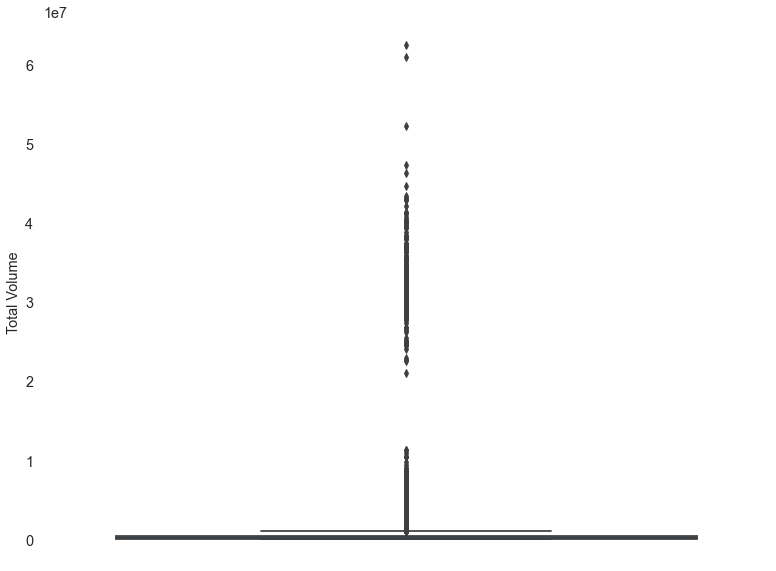

In [13]:
sns.boxplot(y = df['Total Volume']);

We can see there are a lot of outliers in here. This is not an issues of colection data, but the data was collected all over region of the US. Include group region like NorthUs, WestUs, TotalUS. 

So with that, we can easily solve this issues by apply log transform to this columns

C:\Users\PC\anaconda3\envs\dstn\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


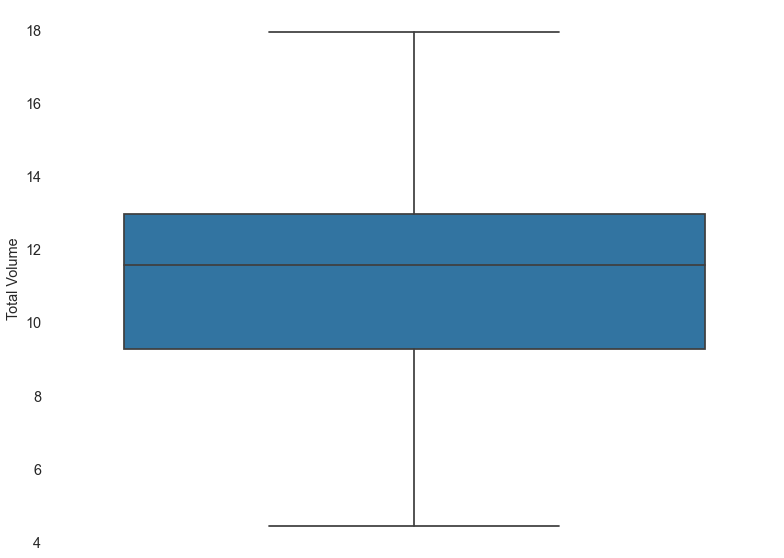

In [14]:
data.loc[:,'Total Volume'] = np.log1p(data['Total Volume'])
sns.boxplot(y = data['Total Volume']);

In [15]:
#Scaling numerical feature
scaler = StandardScaler()
data[['Total Volume', 'month', 'year']] = scaler.fit_transform(data[['Total Volume', 'month', 'year']])
data[['AveragePrice', 'Total Volume', 'month', 'year']].corr()

C:\Users\PC\anaconda3\envs\dstn\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\PC\anaconda3\envs\dstn\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


AveragePrice  Total Volume     month      year
AveragePrice      1.000000     -0.583411  0.162409  0.093197
Total Volume     -0.583411      1.000000 -0.034262  0.086274
month             0.162409     -0.034262  1.000000 -0.177050
year              0.093197      0.086274 -0.177050  1.000000

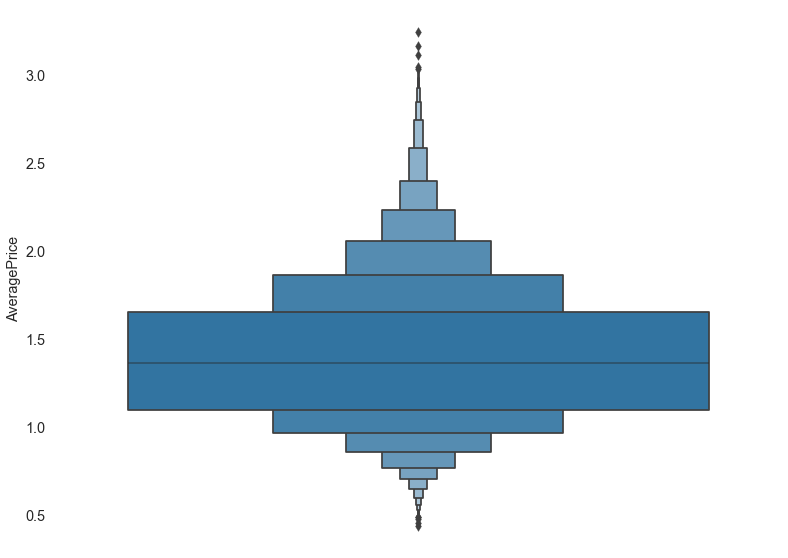

In [16]:
sns.boxenplot(y = data['AveragePrice']);

There are a liite out liers here, but we should exclude them for a better regressor later on.

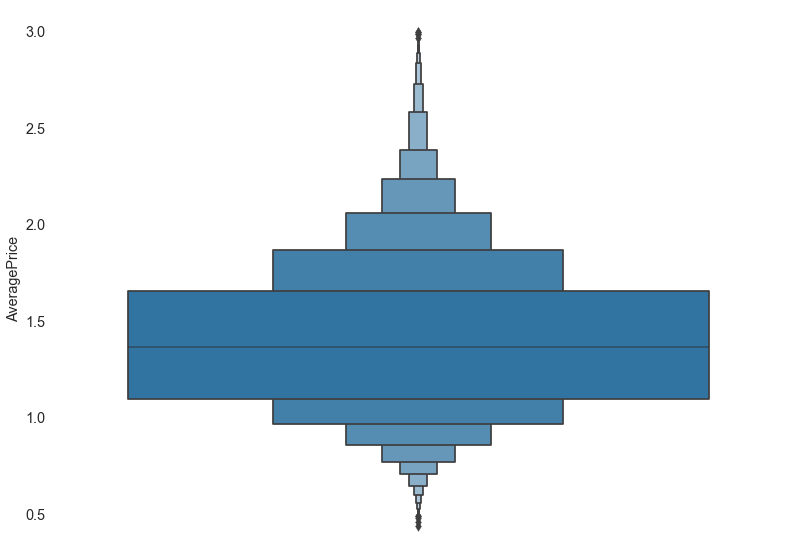

In [17]:
data = data[~(data['AveragePrice'] > 3.0)]
df = df[~(df['AveragePrice'] > 3.0)]
sns.boxenplot(y = data['AveragePrice']);

In [18]:
data.columns

Index(['Total Volume', 'region', 'type', 'year', 'AveragePrice', 'season',
       'month'],
      dtype='object')

In [19]:
# See correlation between categorical and target
def get_p_oneway(data, column):
    arr = []
    for unique in data[column].unique():
        arr.append(data.loc[data[column] == unique, 'AveragePrice'])
    stat, p = f_oneway(*arr)
    return p

one_ways = pd.DataFrame(columns=['feature', 'p-value', 'relation_with_target'])
row = 0
for c in ['region', 'type', 'season']:
    one_ways.loc[row, 'feature'] = c
    p = get_p_oneway(data, c)
    one_ways.loc[row, 'p-value'] = p
    one_ways.loc[row, 'relation_with_target'] = p <= 0.05
    row+=1


one_ways.sort_values(by='p-value')

feature p-value relation_with_target
0  region     0.0                 True
1    type     0.0                 True
2  season     0.0                 True

In [20]:
# Encoding categorical features
data = pd.get_dummies(data, drop_first=True)
data.head()

Total Volume      year  AveragePrice     month  region_Atlanta  \
0     -0.107282 -1.221282          1.33  1.647632               0   
1     -0.175949 -1.221282          1.35  1.647632               0   
2      0.158690 -1.221282          0.93  1.647632               0   
3     -0.017121 -1.221282          1.08  1.647632               0   
4     -0.207558 -1.221282          1.28  1.364669               0   

   region_BaltimoreWashington  region_Boise  region_Boston  \
0                           0             0              0   
1                           0             0              0   
2                           0             0              0   
3                           0             0              0   
4                           0             0              0   

   region_BuffaloRochester  region_California  ...  region_StLouis  \
0                        0                  0  ...               0   
1                        0                  0  ...               0   
2                        0                  0  ...               0   
3                        0                  0  ...               0   
4                        0                  0  ...               0   

   region_Syracuse  region_Tampa  region_TotalUS  region_West  \
0                0             0               0            0   
1                0             0               0            0   
2                0             0               0            0   
3                0             0               0            0   
4                0             0               0            0   

   region_WestTexNewMexico  type_organic  season_Spring  season_Summer  \
0                        0             0              0              0   
1                        0             0              0              0   
2                        0             0              0              0   
3                        0             0              0              0   
4                        0             0              0              0   

   season_Winter  
0              1  
1              1  
2              1  
3              1  
4              1  

[5 rows x 61 columns]

# Step 4: EDA

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18243 entries, 0 to 11
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          18243 non-null  datetime64[ns]
 1   AveragePrice  18243 non-null  float64       
 2   Total Volume  18243 non-null  float64       
 3   4046          18243 non-null  float64       
 4   4225          18243 non-null  float64       
 5   4770          18243 non-null  float64       
 6   Total Bags    18243 non-null  float64       
 7   Small Bags    18243 non-null  float64       
 8   Large Bags    18243 non-null  float64       
 9   XLarge Bags   18243 non-null  float64       
 10  type          18243 non-null  object        
 11  year          18243 non-null  int64         
 12  region        18243 non-null  object        
 13  season        18243 non-null  object        
dtypes: datetime64[ns](1), float64(9), int64(1), object(3)
memory usage: 2.1+ MB


In [22]:
df.head()

Date  AveragePrice  Total Volume     4046       4225    4770  \
0 2015-12-27          1.33      64236.62  1036.74   54454.85   48.16   
1 2015-12-20          1.35      54876.98   674.28   44638.81   58.33   
2 2015-12-13          0.93     118220.22   794.70  109149.67  130.50   
3 2015-12-06          1.08      78992.15  1132.00   71976.41   72.58   
4 2015-11-29          1.28      51039.60   941.48   43838.39   75.78   

   Total Bags  Small Bags  Large Bags  XLarge Bags          type  year  \
0     8696.87     8603.62       93.25          0.0  conventional  2015   
1     9505.56     9408.07       97.49          0.0  conventional  2015   
2     8145.35     8042.21      103.14          0.0  conventional  2015   
3     5811.16     5677.40      133.76          0.0  conventional  2015   
4     6183.95     5986.26      197.69          0.0  conventional  2015   

   region  season  
0  Albany  Winter  
1  Albany  Winter  
2  Albany  Winter  
3  Albany  Winter  
4  Albany  Winter

In [23]:
df.tail()

Date  AveragePrice  Total Volume     4046     4225    4770  \
7  2018-02-04          1.63      17074.83  2046.96  1529.20    0.00   
8  2018-01-28          1.71      13888.04  1191.70  3431.50    0.00   
9  2018-01-21          1.87      13766.76  1191.92  2452.79  727.94   
10 2018-01-14          1.93      16205.22  1527.63  2981.04  727.01   
11 2018-01-07          1.62      17489.58  2894.77  2356.13  224.53   

    Total Bags  Small Bags  Large Bags  XLarge Bags     type  year  \
7     13498.67    13066.82      431.85          0.0  organic  2018   
8      9264.84     8940.04      324.80          0.0  organic  2018   
9      9394.11     9351.80       42.31          0.0  organic  2018   
10    10969.54    10919.54       50.00          0.0  organic  2018   
11    12014.15    11988.14       26.01          0.0  organic  2018   

              region  season  
7   WestTexNewMexico  Spring  
8   WestTexNewMexico  Spring  
9   WestTexNewMexico  Spring  
10  WestTexNewMexico  Spring  
11  WestTexNewMexico  Spring

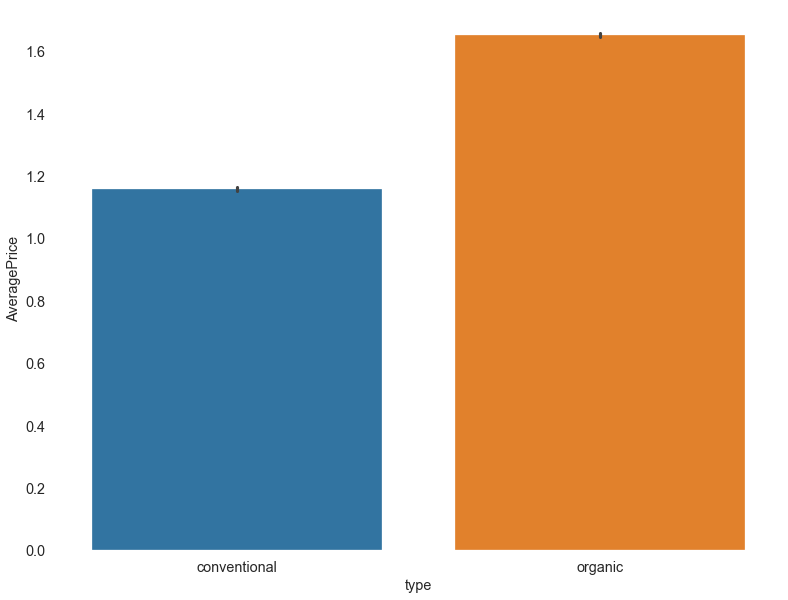

In [24]:
# Does type of avocado affect its price?
sns.barplot(data=df, x='type', y="AveragePrice");

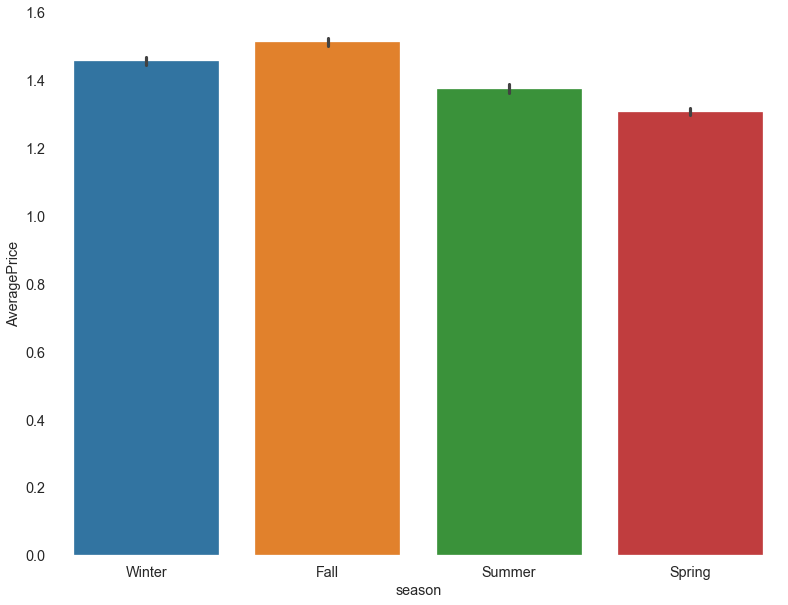

In [25]:
# How dose season affect avocado's price?
sns.barplot(data=df, x='season', y="AveragePrice");

The seasonality was also having an effect on average avocado price. The top is at the Fall, the bottom is at the Spring. Maybe the cause of this is because there were abudant harvest on the Spring.

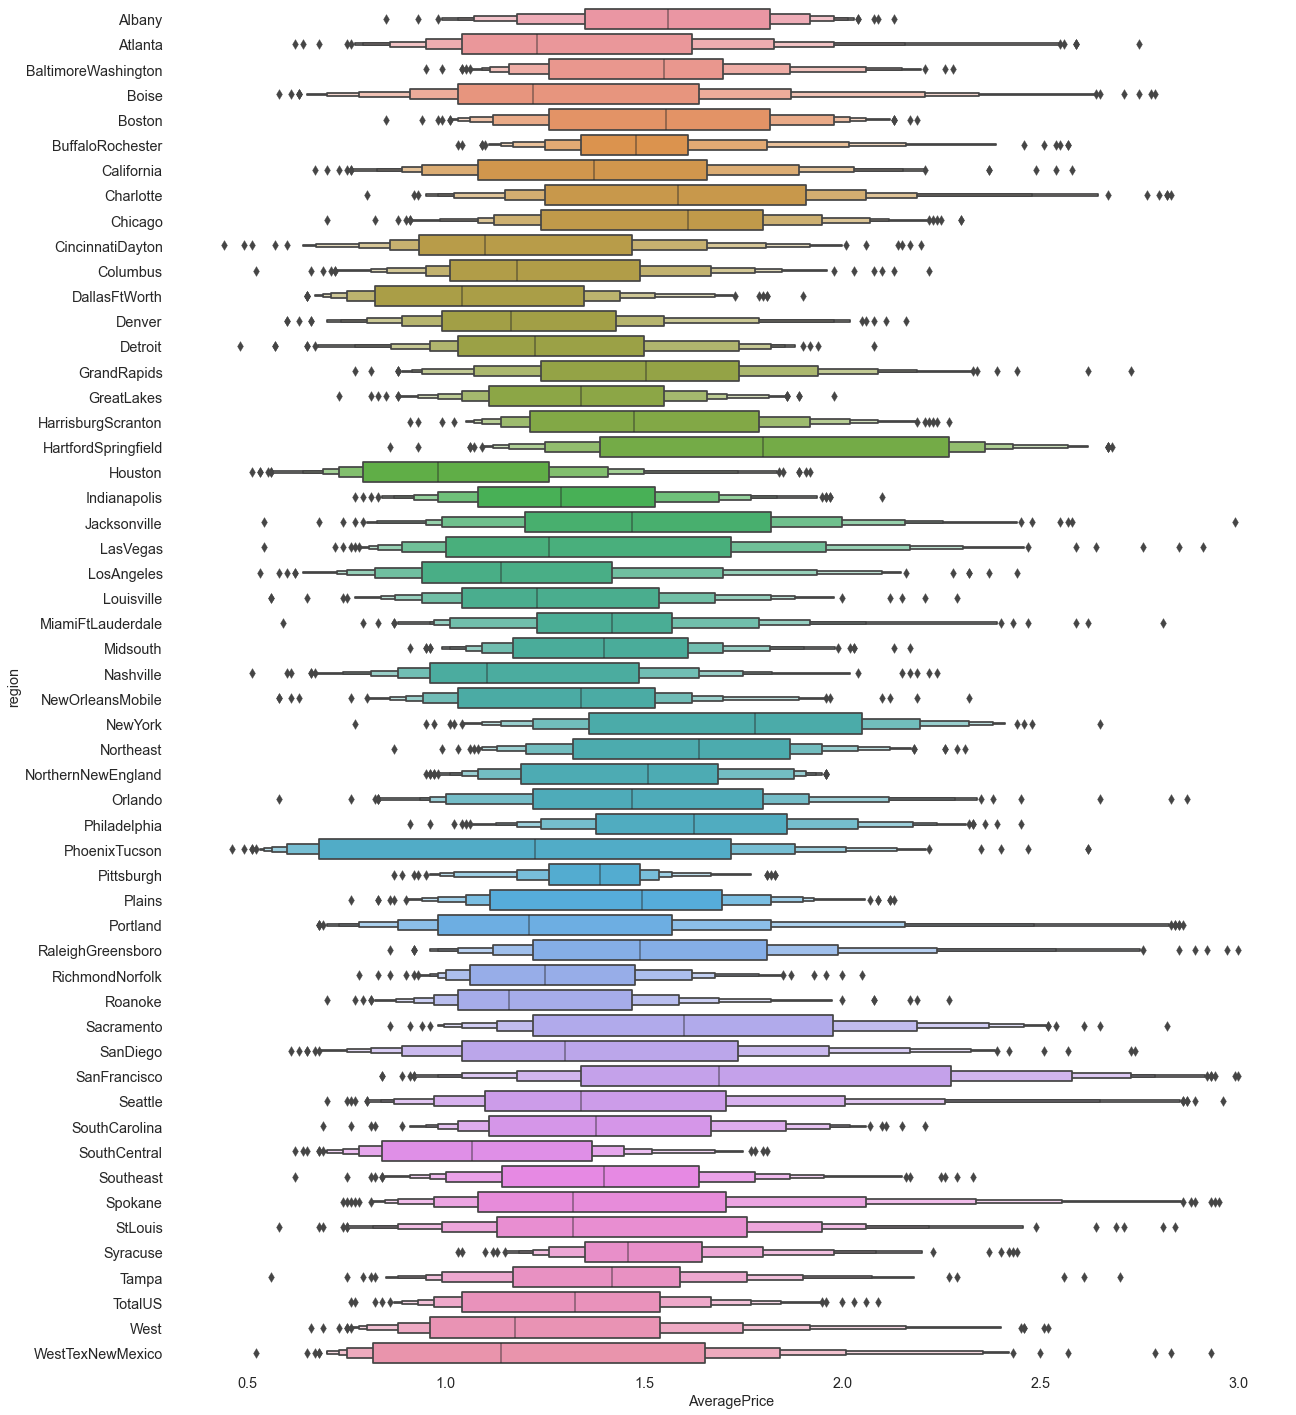

In [26]:
# How dose region affect avocado's price?
plt.figure(figsize=(20,25))
sns.boxenplot(data=df, y='region', x="AveragePrice");

The avocado price sure changes over the US.

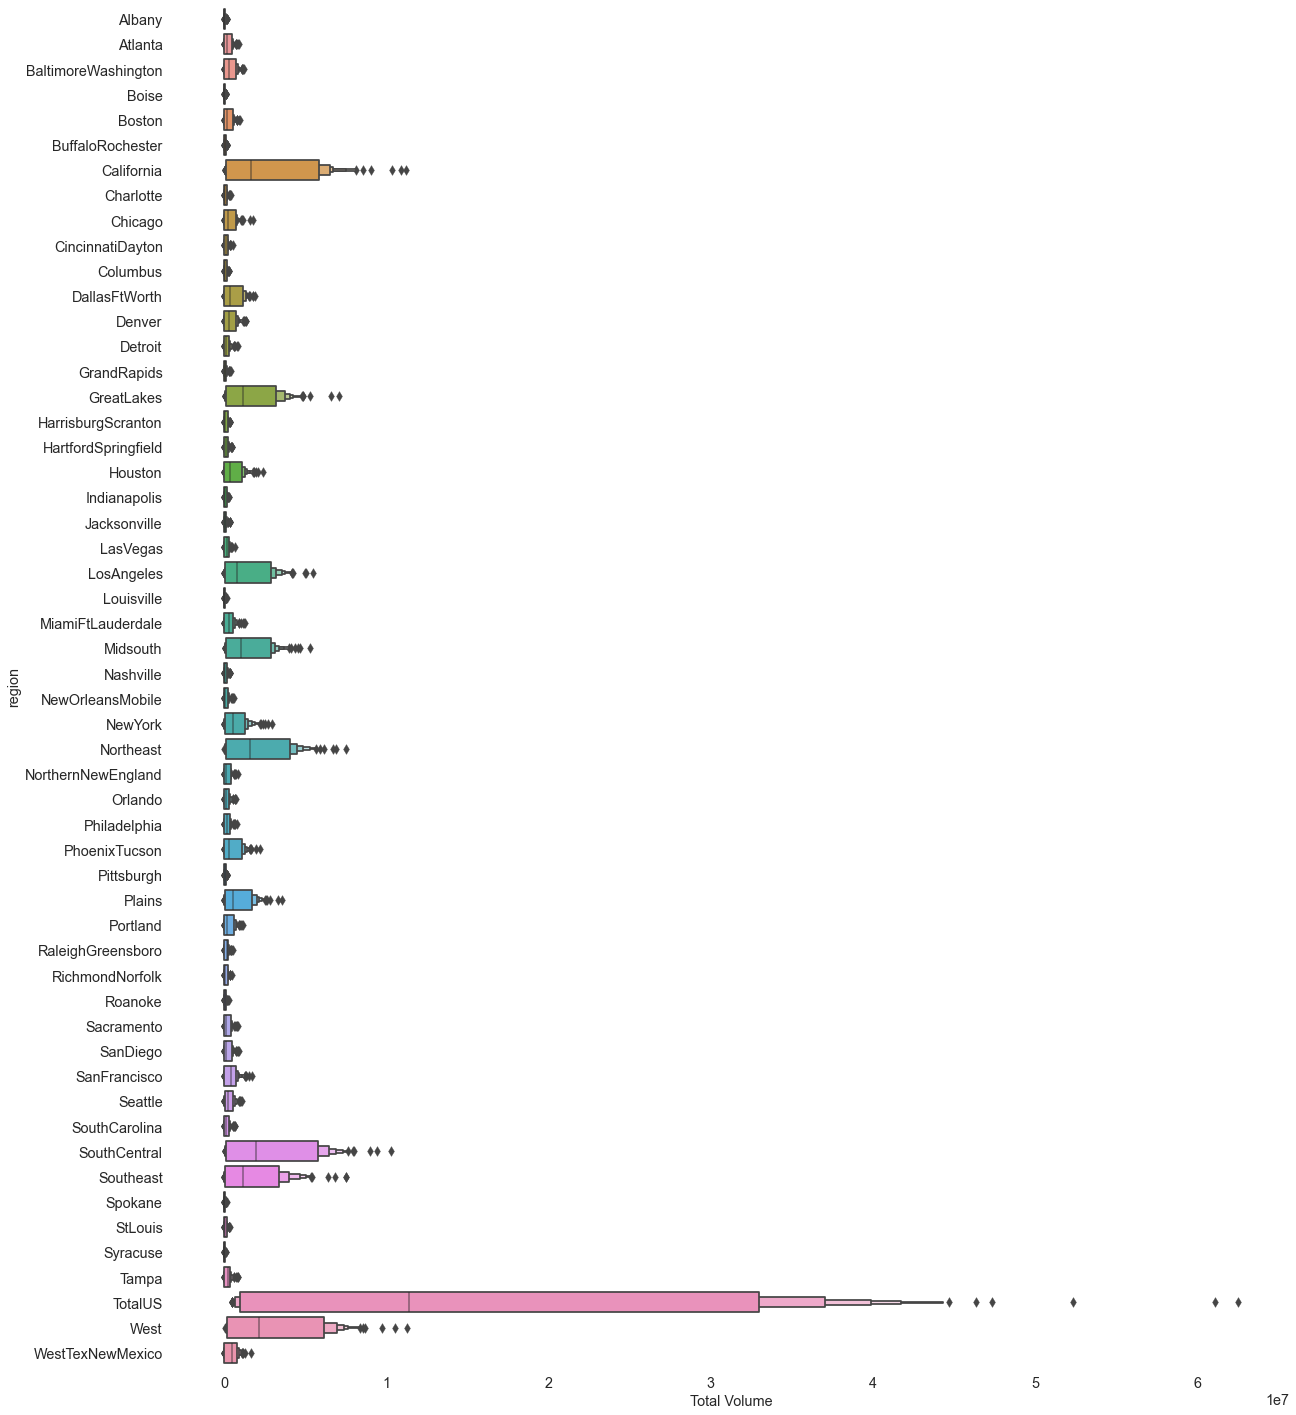

In [27]:
# How much avocado had been sold for each region?
plt.figure(figsize=(20,25))
sns.boxenplot(data=df, y='region', x="Total Volume");

<AxesSubplot:xlabel='year', ylabel='Total Volume'>

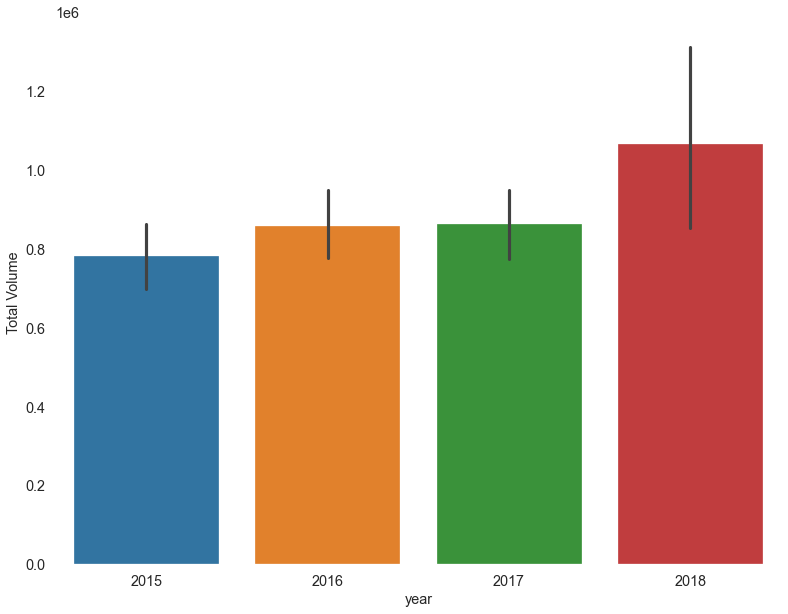

In [28]:
# The year has the highest total volume sell
sns.barplot(data = df, x = 'year', y = 'Total Volume')

Its seems like the volumes has a trend going up over the year. Especially in 2018.

<AxesSubplot:xlabel='season', ylabel='Total Volume'>

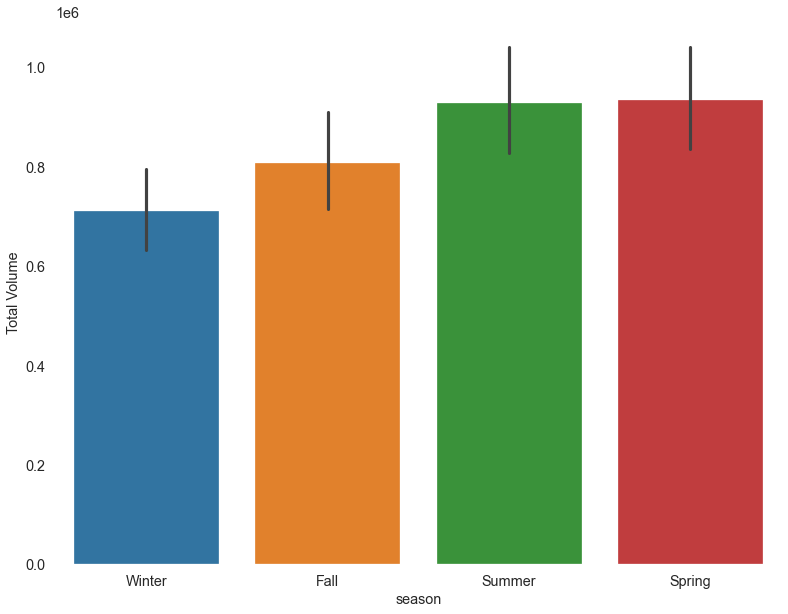

In [29]:
# Did season affects the selling?
sns.barplot(data = df, x = 'season', y = 'Total Volume')

In [30]:
df.columns

Index(['Date', 'AveragePrice', 'Total Volume', '4046', '4225', '4770',
       'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year',
       'region', 'season'],
      dtype='object')

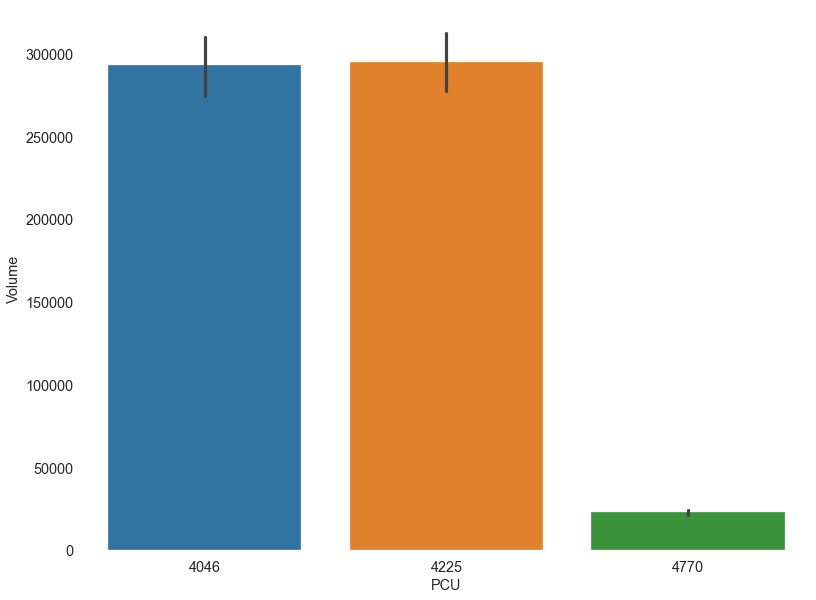

In [31]:
# Which avocado product look up id has the best selling?
temp_table = pd.melt(df[['4046', '4225', '4770']], var_name='PCU', value_name='Volume')
sns.barplot(data = temp_table, x = 'PCU', y = 'Volume');

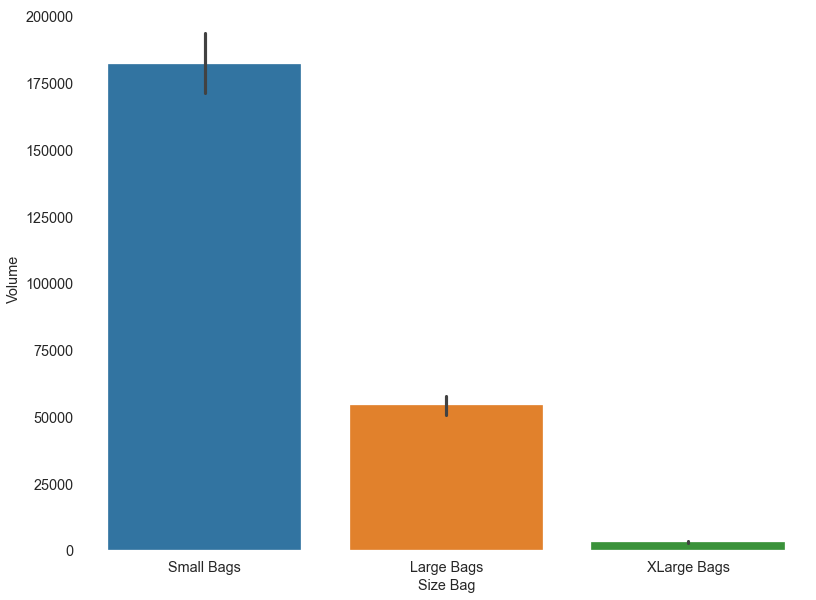

In [32]:
# How much the customer will buy in each time?
temp_table = pd.melt(df[['Small Bags', 'Large Bags', 'XLarge Bags']], var_name='Size Bag', value_name='Volume')
sns.barplot(data = temp_table, x = 'Size Bag', y = 'Volume');


We can see, the customers usually bought small size of bag each time, rather than larger one. So maybe our strategy should focus on the quality of the avocado but not the quantity.

# Step 5: Build model

In [33]:
def split_x_y(data):
    X = data.copy()
    y = X.pop('AveragePrice')
    return X,y

In [34]:
#Split train and test
X, y = split_x_y(data)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state=0)

In [38]:
# run model 8x with 60/30 split intentionally leaving out 10%
cv_split = ShuffleSplit(n_splits = 5, test_size = .3,
                        train_size = .6, random_state = 0)

In [42]:
#Define param_grids
param_grids = [
    #Random Forest
    {'n_estimators': [100, 200],
     'max_features': ['auto', 'log2'],
     'criterion': ["friedman_mse", "poisson"]},

    #KNN
    {'n_neighbors': list(range(2, 20, 2))},

    #LinearRegression
    {'fit_intercept': [True, False]},

    #SVR
    {'C': [1, 10, 100],
     'gamma': [0.1, 1]},

    #Decision Tree
    {'max_depth': [4, 6, 8, None],
     'max_features': ['auto', 'log2'],
     'criterion': ["friedman_mse", "poisson"]},

    #XGBoost
    {},

    #BaggingRegressor
    {'n_estimators': [10, 20],
     'warm_start':[True, False]}
]

MLA = [
    RandomForestRegressor(),
    KNeighborsRegressor(),
    LinearRegression(),
    SVR(),
    DecisionTreeRegressor(),
    XGBRegressor(),
    BaggingRegressor()
]

In [43]:
scoring = pd.DataFrame(columns=['algorithm', 'best_params', 'score_train', 'score_test', 'fit_time'])
row = 0

start_total = time.perf_counter()
for mla, param in zip(MLA, param_grids):
    rscv = GridSearchCV(mla, param, cv = cv_split, return_train_score=True, n_jobs=4)
    rscv.fit(X_train, y_train)

    best_index = rscv.best_index_
    scoring.loc[row, 'algorithm'] = rscv.best_estimator_.__class__.__name__
    scoring.loc[row, 'best_params'] = str(rscv.best_params_)
    scoring.loc[row, 'score_train'] = rscv.cv_results_['mean_train_score'][best_index]
    scoring.loc[row, 'score_test'] = rscv.cv_results_['mean_test_score'][best_index]
    scoring.loc[row, 'fit_time'] = rscv.cv_results_['mean_fit_time'][best_index]
    print(f'Completed estimation for {rscv.best_estimator_.__class__.__name__}')
    row+=1

run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

Completed estimation for RandomForestRegressor
Completed estimation for KNeighborsRegressor
Completed estimation for LinearRegression
Completed estimation for SVR
Completed estimation for DecisionTreeRegressor
Completed estimation for XGBRegressor
Completed estimation for BaggingRegressor
Total optimization time was 4.96 minutes.


In [44]:
scoring.sort_values(by='score_test', ascending=False)

algorithm                                        best_params  \
3                    SVR                           {'C': 100, 'gamma': 0.1}   
0  RandomForestRegressor  {'criterion': 'friedman_mse', 'max_features': ...   
6       BaggingRegressor          {'n_estimators': 20, 'warm_start': False}   
5           XGBRegressor                                                 {}   
1    KNeighborsRegressor                                 {'n_neighbors': 2}   
4  DecisionTreeRegressor  {'criterion': 'friedman_mse', 'max_depth': Non...   
2       LinearRegression                            {'fit_intercept': True}   

  score_train score_test   fit_time  
3    0.940358   0.893755  20.472246  
0    0.982722   0.873595   9.848753  
6    0.978871   0.866157   1.214752  
5    0.935244   0.864249   1.497196  
1    0.953412   0.823456    0.01815  
4         1.0   0.773656   0.080984  
2    0.705599   0.698002    0.07756


Take a look at the result table above, we can see SVR is the best model. It has the best score in test_set, small variation score in train and test. There a small sign of overfiting, but in overall it look best in all.

# Step 6: Create best model and Report

In [45]:
#Init bestmodel
best_model = SVR(gamma=0.1, C=100)
best_model.fit(X_train, y_train)

SVR(C=100, gamma=0.1)

In [60]:
final_model_score = f'Score on test data: {best_model.score(X_test, y_test)}, score on train data: {best_model.score(X_train, y_train)}'
final_model_score

'Score on test data: 0.9367595443807681, score on train data: 0.9376123145348204'

In [46]:
y_pred = best_model.predict(X_test)

In [47]:
y_test_np = np.array(y_test)

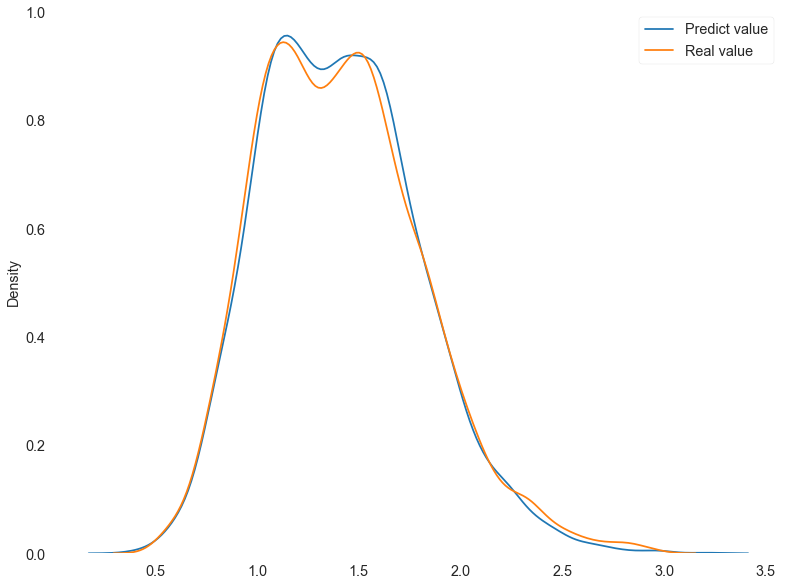

In [48]:
f, ax = plt.subplots()
sns.kdeplot(x = y_pred, label = 'Predict value', ax = ax)
sns.kdeplot(x = y_test_np, label = 'Real value', ax = ax)

plt.legend()
plt.show()

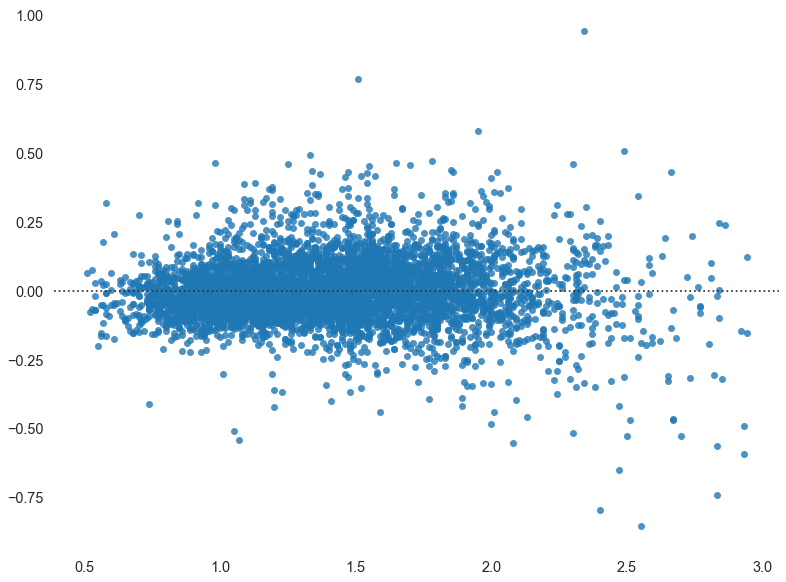

In [49]:
sns.residplot(x = y_test_np, y= y_pred);

In [58]:
true_std = round(np.std(y_test_np),2)
predict_std = round(mean_squared_error(y_test, y_pred),2)
print(f'True std: {true_std}, predict std: {predict_std}. Ratio between them is {true_std/predict_std}')

True std: 0.4, predict std: 0.01. Ratio between them is 40.0



The standard deviation in real life price is complicated than 40 times than the predict one. By that, we can use it to see the smoothly change avocado price for the future. It should give us a overall looking, than the mess reality one.

Now, let's move on next step. We will use predict model to see, which region will be a potential place for us to extends business.

In [51]:
best_model.fit(X, y)

SVR(C=100, gamma=0.1)

In [61]:
#Createing a pred demand features for analysis
viewing = df.copy()
viewing['pred_AveragePrice'] = best_model.predict(X)
viewing['pred_demand'] = viewing['pred_AveragePrice'] * viewing['Total Volume']
viewing.head()

Date  AveragePrice  Total Volume     4046       4225    4770  \
0 2015-12-27          1.33      64236.62  1036.74   54454.85   48.16   
1 2015-12-20          1.35      54876.98   674.28   44638.81   58.33   
2 2015-12-13          0.93     118220.22   794.70  109149.67  130.50   
3 2015-12-06          1.08      78992.15  1132.00   71976.41   72.58   
4 2015-11-29          1.28      51039.60   941.48   43838.39   75.78   

   Total Bags  Small Bags  Large Bags  XLarge Bags          type  year  \
0     8696.87     8603.62       93.25          0.0  conventional  2015   
1     9505.56     9408.07       97.49          0.0  conventional  2015   
2     8145.35     8042.21      103.14          0.0  conventional  2015   
3     5811.16     5677.40      133.76          0.0  conventional  2015   
4     6183.95     5986.26      197.69          0.0  conventional  2015   

   region  season  pred_AveragePrice    pred_demand  
0  Albany  Winter           1.211410   77816.900446  
1  Albany  Winter           1.273580   69890.226611  
2  Albany  Winter           0.953260  112694.603895  
3  Albany  Winter           1.126856   89012.754755  
4  Albany  Winter           1.295046   66098.646843

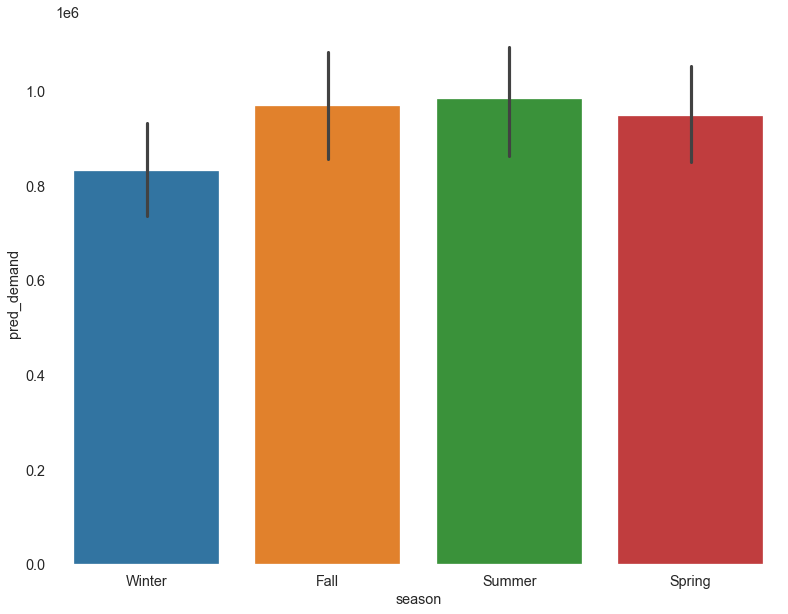

In [62]:
#Which season giving the highest demand
sns.barplot(data=viewing, x='season', y="pred_demand");


The demands will be raising in the fall and summer, we should have a banner to attract customer in the spring, and focus selling, taking profit on the fall or summer. 

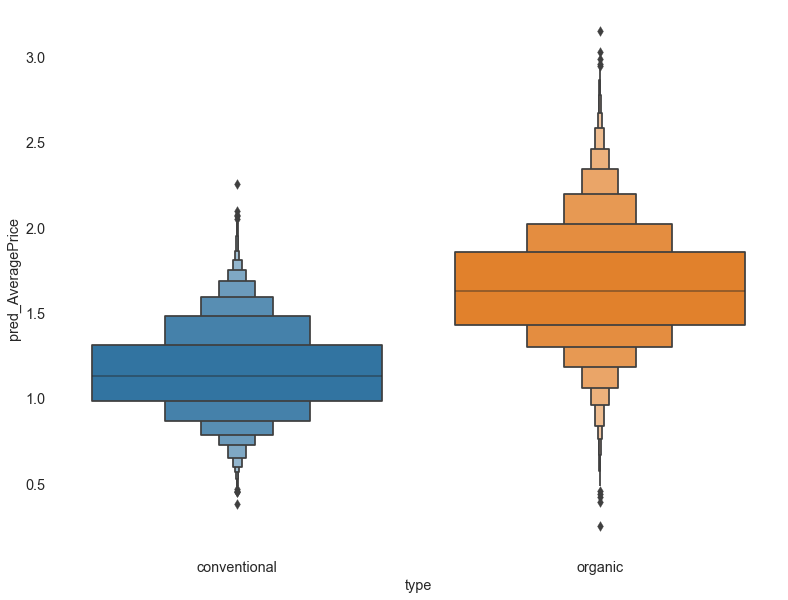

In [63]:
#Which type of avocado giving the highest demand?
sns.boxenplot(data=viewing, x='type', y="pred_AveragePrice");

In [121]:
#Caculate the rasing price by time in a group of region
viewing['diff_price'] = viewing.groupby(['region'])['pred_AveragePrice'].transform(lambda x: x.diff()).fillna(0)
viewing[['region', 'diff_price']] .head()

region  diff_price
0  Albany    0.000000
1  Albany    0.062170
2  Albany   -0.320320
3  Albany    0.173596
4  Albany    0.168191

In [122]:
avg_diff_demand_region_view = viewing[['region', 'diff_price']].groupby(['region']).mean()
avg_diff_demand_region_view = avg_diff_demand_region_view.sort_values(by = 'diff_price', ascending=False)
avg_diff_demand_region_view.head()

diff_price
region                      
SanFrancisco        0.003606
PhoenixTucson       0.003466
SanDiego            0.003317
WestTexNewMexico    0.003144
Sacramento          0.003110

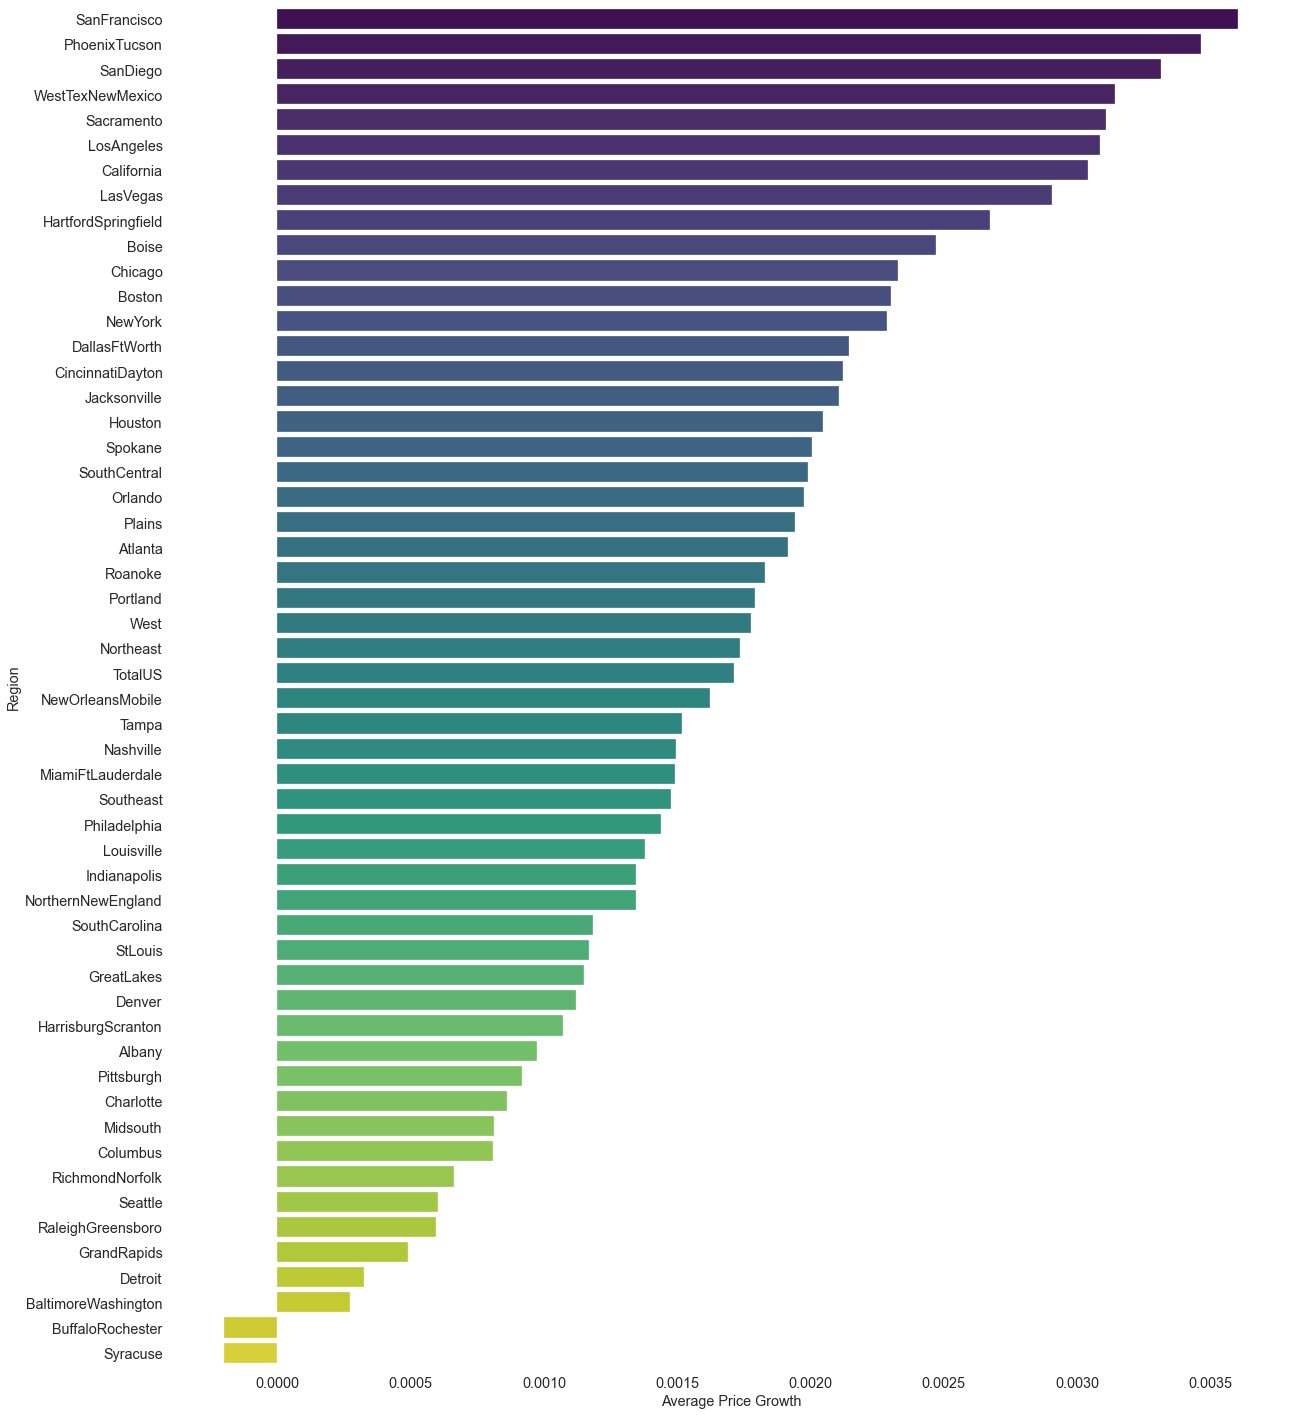

In [124]:
#Which region is growing demand most?
plt.figure(figsize=(20,25))
ax = sns.barplot(y = avg_diff_demand_region_view.index, x = avg_diff_demand_region_view['diff_price'], palette = 'viridis')
ax.set(xlabel='Average Price Growth', ylabel='Region')
plt.show()

We can see that SanFancisco, PhoenixTuscon, SanDiego are the most potential region to invest.

## Save model for later use

In [56]:
import pickle

In [57]:
#Saving model
with open('models/regression_price_model', 'wb') as files:
    pickle.dump(best_model, files)